## Imports and constants

In [1]:
import os
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

from onix.data_tools import get_experiment_data, open_analysis_folder, get_analysis_file_path
from onix.helpers import data_identifier, console_bold

%matplotlib inline

In [2]:
name = "Fluorescence Decay"
analysis_number = None
identifier = None

In [3]:
def add_label(ax, x=0.02, y=1.1):
    ax.text(x, y, identifier, transform=ax.transAxes)

In [1]:
class FluorescenceDecay:
    def __init__(self, data_signal, data_background=None):
        self._data_signal = data_signal
        self._data_background = data_background
        self._average_data()

    def _average_data(self):
        self._times = self._data_signal[0]["pmt_times"]
        if self._data_background is not None and self._times != self._data_background[0]["pmt_times"]:
            raise Exception("Signal and background data must be taken using the same timing parameters.")
        self.times_ms = self._times * 1e3
        signal_voltages = self._data_signal[0]["pmt_voltages"]
        self.V_signal_avg = np.average(signal_voltages, axis=1)
        self.V_signal_err = np.std(signal_voltages, axis=1) / np.sqrt(len(signal_voltages))
        if self._data_background is not None:
            background_voltages = self._data_signal[0]["pmt_voltages"]
            self.V_background_avg = np.average(background_voltages, axis=1)
            self.V_background_err = np.std(background_voltages, axis=1) / np.sqrt(len(background_voltages))
            self.V_diff_avg = self.V_signal_avg - self.V_background_avg
            self.V_diff_err = np.sqrt(self.V_signal_err ** 2 + self.V_background_err ** 2)
        else:
            self.V_background_avg = None
            self.V_background_err = None
            self.V_diff_avg = self.V_signal_avg
            self.V_diff_err = self.V_signal_err
    
    def get_test_data(self, test_time=10e-6, offset_time=100e-6):
        test_start_time = offset_time * 2
        test_end_time = offset_time * 2 + test_time + excitation_delay * 2
        test_mask = np.bitwise_and(
            self._times > test_start_time,
            self._times <= test_end_time,
        )
        self._test_end = test_end_time + offset_time
        self.test_times_ms = self.times_ms[test_mask]
        self.V_signal_test_avg = self.V_signal_avg[test_times_ms]
        self.V_signal_test_err = self.V_signal_err[test_times_ms]

    def get_decay_data(self, excitation_time=5e-3, excitation_delay=10e-6):
        decay_start_time = self._test_end + excitation_delay * 2 + excitation_time
        decay_mask = self._times > decay_start_time
        self.decay_times_ms = self.times_ms[decay_mask]
        self.V_diff_decay_avg = self.V_diff_avg[decay_mask]
        self.V_diff_decay_err = self.V_diff_err[decay_mask]

## Setup

In [147]:
data_numbers = [82, 83]
data = FluorescenceDecay(get_experiment_data(83), get_experiment_data(82))
identifier = "data " + data_identifier(data_numbers) + ", analysis " + data_identifier([analysis_number])

In [148]:
if input(f"Create new analysis folder? (y/{console_bold('n')}) ") == "y":
    analysis_number = open_analysis_folder(name)
else:
    if input(f"Keep current analysis number of {analysis_number}? ({console_bold('y')}/n) ") == "n":
        analysis_number = int(input("Enter analysis number: "))
identifier = "data " + data_identifier(data_numbers) + ", analysis " + data_identifier([analysis_number])
print(f"Current analysis number is {analysis_number}")

Create new analysis folder? (y/n) y
Current analysis number is 58


## Initial plot

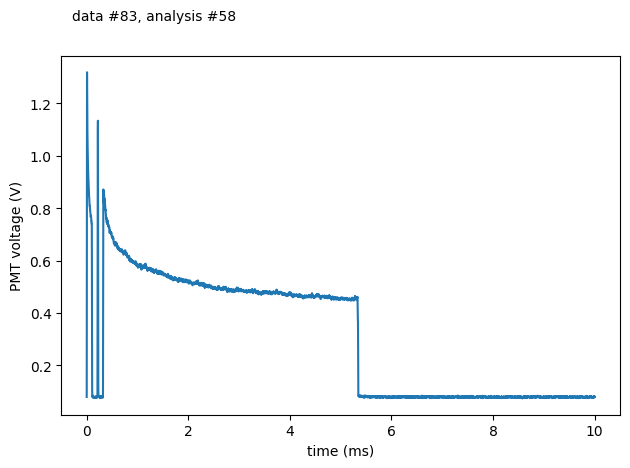

In [149]:
fig, ax = plt.subplots()
summed = None
for kk in data[data_numbers[0]][0]["pmt_voltages"]:
    if summed is None:
        summed = np.zeros(len(kk))
    else:
        summed += kk
summed /= len(data[data_numbers[0]][0]["pmt_voltages"])
ax.plot(data[data_numbers[0]][0]["pmt_times"] * 1e3, summed)
add_label(ax)
ax.set_xlabel("time (ms)")
ax.set_ylabel("PMT voltage (V)")
#ax.set_xlim(0, 1.2)
plt.tight_layout()
plt.savefig(get_analysis_file_path(analysis_number, str(analysis_number) + "_decay.pdf"))
plt.show()